In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point, Polygon, mapping, shape
from pyproj import Proj, transform
import json


In [2]:
from shapely.geometry import LineString, Polygon

EPSG_4326 = Proj(init='EPSG:4326')
DEFAULT_EXPANSION_SIZE = 25000  # Meters


def flatten(geometries):
    combined = geometries.pop() if geometries else None
    for geo in geometries:
        combined = combined.union(geo)
    return combined


def expand_into_polygon(geometry, size=DEFAULT_EXPANSION_SIZE):
    if geometry.geom_type == 'Point':
        coords = _square_of_size(size)
        point = geometry
    elif geometry.geom_type == 'LineString':
        coords = _line_to_strip(geometry, size)
        point = geometry.centroid
    else:
        raise TypeError('Only geometries of type Point or LineString can expand into a Polygon.')
    coords = _local_to_global_coords(coords, point.y, point.x)
    return Polygon(coords)


def _square_of_size(size):
    half = int(size / 2)
    return [(-half, -half), (half, -half), (half, half), (-half, half), (-half, -half)]


def _line_to_strip(line, size):
    coords = global_to_local_coords(line.coords, line.centroid.y, line.centroid.x)
    laea_line = LineString(coords)
    x1, y1 = laea_line.coords[0]
    x2, y2 = laea_line.coords[1]
    angle_r = atan2(y2 - y1, x2 - x1)
    return _make_strip(angle_r, laea_line.length, size=size)


def _make_strip(angle_r, length, size):
    half_size = int(size / 2)
    half_length = (length - size) / 2
    cos_val = cos(angle_r)
    sin_val = sin(angle_r)
    coords = [(-half_size - half_length, -half_size), (half_size + half_length, -half_size),
              (half_size + half_length, half_size), (-half_size - half_length, half_size)]
    return list(map(lambda c: (c[0] * cos_val - c[1] * sin_val, c[0] * sin_val + c[1] * cos_val), coords))


def _laea_projection(anchor_lat, anchor_long):
    return Proj(f'+proj=laea +lat_0={anchor_lat} +lon_0={anchor_long} +ellps=WGS84 +units=m +no_defs')


def _local_to_global_coords(coords, anchor_lat, anchor_long):
    laea_proj = _laea_projection(anchor_lat, anchor_long)
    return [transform(laea_proj, EPSG_4326, y, x) for y, x in coords]


def global_to_local_coords(coords, anchor_lat, anchor_long):
    laea_proj = _laea_projection(anchor_lat, anchor_long)
    return [transform(EPSG_4326, laea_proj, y, x) for y, x in coords]

In [3]:
df = pd.read_csv('latlong.csv')
crs = {'init': 'epsg:4326'}
df.head()

## This code accepts your CSV provided it is constructed with latitude and longitude column

,Latitude,Longitude
0,42.44,33.79


In [4]:
geometry = [Point(xy) for xy in zip( df["Longitude"], df["Latitude"])]
geometry[0:]
gdf = GeoDataFrame(df, geometry = geometry)
#gdf.plot()
gdf['square'] = gpd.GeoSeries(gdf.geometry.apply(expand_into_polygon))
gdf['square_geojson'] = gdf['square'].apply(mapping)

In [5]:
gdf['square_geojson'].to_json('output.json')


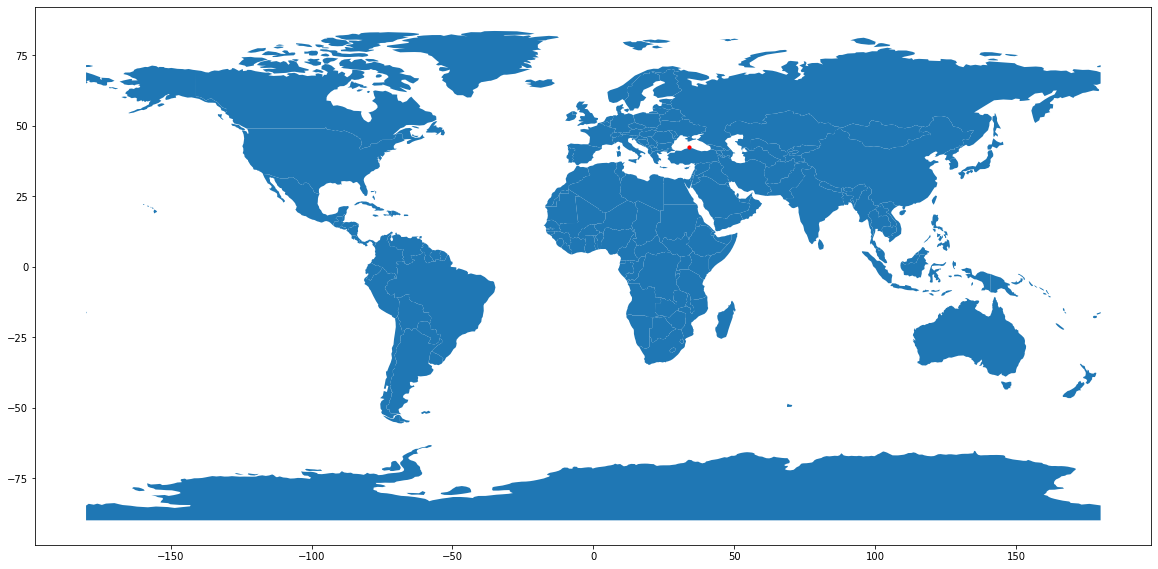

In [6]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(20, 10)), marker='o', color='red' , markersize=10)
## This code here will display your latitude and longitude on a world map